<a href="https://colab.research.google.com/github/iCarrrot/dl_uwr/blob/summer2020/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

**Submission deadline: last lab session before or on Thursday, 02.04.2020**

**Points: 12 + 4 bonus points**

## Submission instructions
**To ease grading, please do not remove the TODO lines, put your code below them!**

The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment3_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restart and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook and paste the link into an appropriate SKOS assignment

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets

from IPython.display import clear_output

# Helper code

The code in this section handles data loading, result validation and plotting. 

In [0]:
def compute_error_rate(model, data_loader, device='cpu'):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)
    
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples

def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    plt.legend()
        
    plt.subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plt.plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    plt.ylim(0, 0.20)
    plt.legend()

## Data preparation

We will download the MNIST data using `torchvision`, then use a fast in-memory loader.

In [0]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """
    __initialized = False
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [
            torch.stack(ts) for ts in zip(*batches)
        ]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [5]:
# Load the data

batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    'train': InMemDataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': InMemDataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': InMemDataLoader(
        _test, batch_size=batch_size, shuffle=False)}

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


# SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs whilel solving the assignments.

In [0]:
def SGD(model, data_loaders, 
        alpha=1e-4, epsilon=0.0, decay=0.0, d=0,
        num_epochs=1, max_num_epochs=np.nan, patience_expansion=1.5,
        log_every=100, device='cpu'):
    
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
    
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(p, device=device) for p in model.parameters()]
    alpha0=alpha

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            #
            # TODO: You can implement learning rate control here (it is updated
            # once per epoch), or below in the loop over minibatches.
            #
                        
            for x, y in data_loaders['train']:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(batch_err_rate)
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(),
                                            velocities):
                        if 'weight' in name:
                            #
                            # TODO: Implement weight decay (L2 regularization
                            # on weights by changing the gradients
                            p.grad += decay * p
                        

                        #
                        # TODO: Implement a learning rate schedule
                        # Hint: You can use the iteration or epoch counters
                        alpha = alpha0 * np.e ** (-d * epoch)

                        #
                        # TODO: If needed, implement here a momentum schedule
                        # epsilon = TODO
                        #

                        #
                        # TODO: Implement velocity updates for momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        #
                        v[...] = v * epsilon - alpha * p.grad

                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 
                        p += v
                        
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), batch_err_rate * 100.0, num_iter / (time.time() - tstart)))
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate * 100.0, num_epochs)
            print('{0}\n{1}\n{0}'.format('-' * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

----------------------------------------------------------
After epoch 14 | valid err rate: 10.81% | doing  14 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 9)

-------------------------------------------
Test error rate: 11.170%, training took 6s.
-------------------------------------------


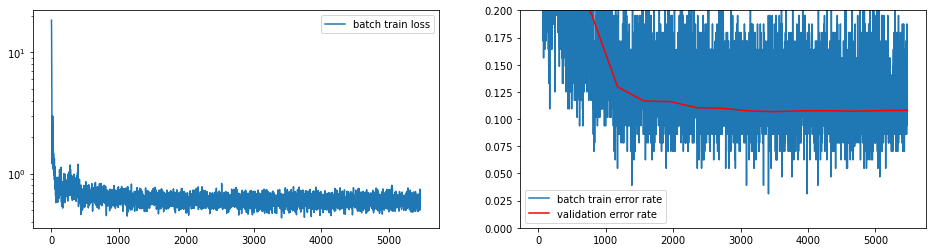

In [21]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Linear(28*28, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.5)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, max_num_epochs=30, device='cuda', epsilon=0.9, d=0.6, decay=0.5)


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")
print('{0}\n{1}\n{0}'.format('-' * len(m), m))

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

# Problem 3: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

# Problem 4: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer 
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

# Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transfromations during training, use a data loader that re-computes them for each training minibatch. The `InMemoryDataloader` assumes that the transformations are deterministic and applies them only once.

# Problem 6: Batch Normalization [1p bonus]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 7: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 8: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 9: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

# Problem 10: Other tricks [1-many bonus pounts]

The neural network literature is ful of trickss for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand